In [1]:
# 数据过滤
import sys
sys.path.append(r"D:\工作\QuantRobot")
from online_system.index_cal import get_all_cleaned_data
path = rf'D:\工作\TradeData\spot'
datas = get_all_cleaned_data(path)

# 获取最新交易日期
max_date = datas['date'].max()

# 过滤出有最新数据的tic
recent_tics = datas[datas['date'] == max_date]['tic'].unique()
filtered_data = datas[datas['tic'].isin(recent_tics)]

# 过滤掉交易日期小于200天的tic
tic_counts = filtered_data.groupby('tic')['date'].nunique()
filtered_tics = tic_counts[tic_counts >= 800].index
filtered_data = filtered_data[filtered_data['tic'].isin(filtered_tics)]

# 计算30天平均交易量
filtered_data['volume_30d_avg'] = filtered_data.groupby('tic')['volume'].rolling(30).mean().reset_index(level=0, drop=True)

# 过滤掉30天平均交易量小于100万的tic
cal_date = filtered_data['date'].max()
high_volume_tics = filtered_data[(filtered_data['volume_30d_avg'] > 1e6) & (filtered_data['date'] == cal_date)]['tic'].unique()
filtered_data = filtered_data[filtered_data['tic'].isin(high_volume_tics)]

#过滤掉不能交易的交易对
tics =['USDTUSDC','USDCUSDT','DAIUSDT']
filtered_data = filtered_data[~filtered_data['tic'].isin(tics)]

In [2]:
# 预测每个交易对的未来数据
from prophet import Prophet
import pandas as pd
forecast_df = pd.DataFrame()
for tic in filtered_data['tic'].unique():
    temp = filtered_data[filtered_data['tic']==tic]
    df = temp[['date','close']]
    df.columns= ['ds','y']
    df['ds'] = df['ds'].dt.tz_localize(None)
    df['floor'] = 0
    m = Prophet(changepoint_prior_scale=0.1,
                seasonality_mode='multiplicative',
                seasonality_prior_scale=10,
                changepoint_range = 0.9)
    m.fit(df)
    future = m.make_future_dataframe(periods=120)
    forecast = m.predict(future)
    forecast['tic'] = tic
    if forecast['yhat'].min() <0: #过滤掉哪些不正常的预测
        continue
    forecast_df = forecast_df.append(forecast)

08:37:22 - cmdstanpy - INFO - Chain [1] start processing
08:37:22 - cmdstanpy - INFO - Chain [1] done processing
08:37:23 - cmdstanpy - INFO - Chain [1] start processing
08:37:23 - cmdstanpy - INFO - Chain [1] done processing
08:37:24 - cmdstanpy - INFO - Chain [1] start processing
08:37:25 - cmdstanpy - INFO - Chain [1] done processing
08:37:26 - cmdstanpy - INFO - Chain [1] start processing
08:37:26 - cmdstanpy - INFO - Chain [1] done processing
08:37:27 - cmdstanpy - INFO - Chain [1] start processing
08:37:28 - cmdstanpy - INFO - Chain [1] done processing
08:37:28 - cmdstanpy - INFO - Chain [1] start processing
08:37:29 - cmdstanpy - INFO - Chain [1] done processing
08:37:29 - cmdstanpy - INFO - Chain [1] start processing
08:37:30 - cmdstanpy - INFO - Chain [1] done processing
08:37:30 - cmdstanpy - INFO - Chain [1] start processing
08:37:31 - cmdstanpy - INFO - Chain [1] done processing
08:37:31 - cmdstanpy - INFO - Chain [1] start processing
08:37:32 - cmdstanpy - INFO - Chain [1]

08:38:36 - cmdstanpy - INFO - Chain [1] done processing
08:38:37 - cmdstanpy - INFO - Chain [1] start processing
08:38:37 - cmdstanpy - INFO - Chain [1] done processing
08:38:38 - cmdstanpy - INFO - Chain [1] start processing
08:38:39 - cmdstanpy - INFO - Chain [1] done processing
08:38:39 - cmdstanpy - INFO - Chain [1] start processing
08:38:39 - cmdstanpy - INFO - Chain [1] done processing
08:38:40 - cmdstanpy - INFO - Chain [1] start processing
08:38:40 - cmdstanpy - INFO - Chain [1] done processing
08:38:41 - cmdstanpy - INFO - Chain [1] start processing
08:38:41 - cmdstanpy - INFO - Chain [1] done processing
08:38:42 - cmdstanpy - INFO - Chain [1] start processing
08:38:42 - cmdstanpy - INFO - Chain [1] done processing
08:38:43 - cmdstanpy - INFO - Chain [1] start processing
08:38:43 - cmdstanpy - INFO - Chain [1] done processing
08:38:44 - cmdstanpy - INFO - Chain [1] start processing
08:38:44 - cmdstanpy - INFO - Chain [1] done processing
08:38:45 - cmdstanpy - INFO - Chain [1] 

In [3]:
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,tic
0,2020-12-25,1.198082,0.885086,1.652521,1.198082,1.198082,0.057831,0.057831,0.057831,0.001560,0.001560,0.001560,0.056271,0.056271,0.056271,0.0,0.0,0.0,1.267368,1INCHUSDT
1,2020-12-26,1.240326,0.899815,1.676920,1.240326,1.240326,0.055698,0.055698,0.055698,0.004683,0.004683,0.004683,0.051015,0.051015,0.051015,0.0,0.0,0.0,1.309410,1INCHUSDT
2,2020-12-27,1.282571,0.953154,1.712332,1.282571,1.282571,0.043105,0.043105,0.043105,-0.001240,-0.001240,-0.001240,0.044345,0.044345,0.044345,0.0,0.0,0.0,1.337856,1INCHUSDT
3,2020-12-28,1.324816,0.986504,1.759667,1.324816,1.324816,0.031651,0.031651,0.031651,-0.004644,-0.004644,-0.004644,0.036296,0.036296,0.036296,0.0,0.0,0.0,1.366748,1INCHUSDT
4,2020-12-29,1.367060,1.019875,1.770237,1.367060,1.367060,0.015198,0.015198,0.015198,-0.011743,-0.011743,-0.011743,0.026941,0.026941,0.026941,0.0,0.0,0.0,1.387837,1INCHUSDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,2024-07-12,0.533694,0.125652,0.551984,0.309202,0.792530,-0.378323,-0.378323,-0.378323,0.007803,0.007803,0.007803,-0.386126,-0.386126,-0.386126,0.0,0.0,0.0,0.331785,ZRXUSDT
1655,2024-07-13,0.534561,0.113565,0.547304,0.305540,0.795435,-0.378356,-0.378356,-0.378356,0.007437,0.007437,0.007437,-0.385793,-0.385793,-0.385793,0.0,0.0,0.0,0.332307,ZRXUSDT
1656,2024-07-14,0.535429,0.119245,0.537001,0.301285,0.798183,-0.383187,-0.383187,-0.383187,0.002211,0.002211,0.002211,-0.385398,-0.385398,-0.385398,0.0,0.0,0.0,0.330259,ZRXUSDT
1657,2024-07-15,0.536296,0.107112,0.528203,0.297030,0.800931,-0.396493,-0.396493,-0.396493,-0.011548,-0.011548,-0.011548,-0.384944,-0.384944,-0.384944,0.0,0.0,0.0,0.323659,ZRXUSDT


In [5]:
tic = 'BTCUSDT'
single_df = forecast_df[forecast_df['tic']==tic]
max_date = pd.to_datetime(max_date)

# 现在进行比较
predict_df = single_df[single_df['ds'] > max_date]
predict_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,tic
1537,2024-03-19,58227.375039,65361.926661,71415.021699,58227.375039,58227.375039,0.173503,0.173503,0.173503,0.000291,0.000291,0.000291,0.173213,0.173213,0.173213,0.0,0.0,0.0,68330.018788,BTCUSDT
1538,2024-03-20,58424.275741,65962.239290,72067.889069,58424.275741,58424.275741,0.181957,0.181957,0.181957,0.004445,0.004445,0.004445,0.177511,0.177511,0.177511,0.0,0.0,0.0,69054.958116,BTCUSDT
1539,2024-03-21,58621.176443,66339.643968,71935.188242,58621.176443,58621.176443,0.180432,0.180432,0.180432,-0.001004,-0.001004,-0.001004,0.181436,0.181436,0.181436,0.0,0.0,0.0,69198.319991,BTCUSDT
1540,2024-03-22,58818.077145,66421.315451,72726.539593,58818.077145,58818.077145,0.183822,0.183822,0.183822,-0.001128,-0.001128,-0.001128,0.184950,0.184950,0.184950,0.0,0.0,0.0,69630.141906,BTCUSDT
1541,2024-03-23,59014.977847,67064.699075,72844.479851,59014.977847,59014.977847,0.185550,0.185550,0.185550,-0.002477,-0.002477,-0.002477,0.188027,0.188027,0.188027,0.0,0.0,0.0,69965.188633,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,2024-07-12,80870.955784,54827.407126,75306.054402,69071.102238,93401.205945,-0.198295,-0.198295,-0.198295,-0.001128,-0.001128,-0.001128,-0.197167,-0.197167,-0.197167,0.0,0.0,0.0,64834.673616,BTCUSDT
1653,2024-07-13,81067.856486,55006.411381,75322.926517,69091.393735,93752.861601,-0.197620,-0.197620,-0.197620,-0.002477,-0.002477,-0.002477,-0.195143,-0.195143,-0.195143,0.0,0.0,0.0,65047.236672,BTCUSDT
1654,2024-07-14,81264.757188,55500.398502,75395.027821,69247.732559,94086.632277,-0.194394,-0.194394,-0.194394,-0.001687,-0.001687,-0.001687,-0.192707,-0.192707,-0.192707,0.0,0.0,0.0,65467.345622,BTCUSDT
1655,2024-07-15,81461.657890,55942.335304,76733.870783,69341.170735,94549.756167,-0.188300,-0.188300,-0.188300,0.001560,0.001560,0.001560,-0.189860,-0.189860,-0.189860,0.0,0.0,0.0,66122.392413,BTCUSDT


In [6]:
import numpy as np
np.mean((predict_df['yhat_upper']-predict_df['yhat_lower'])/predict_df['yhat'])

0.16193928110435377

<AxesSubplot:>

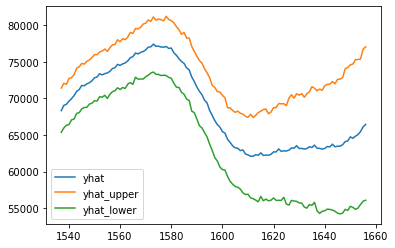

In [7]:
predict_df.plot(y=['yhat','yhat_upper','yhat_lower'])

<AxesSubplot:>

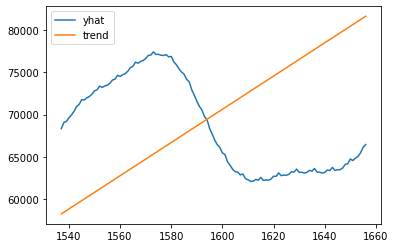

In [8]:
predict_df.plot(y=['yhat','trend'])

In [9]:
predict_df['yhat'].max()

77429.56150979521

In [10]:
import numpy as np
static_df = pd.DataFrame()

for tic in forecast_df['tic'].unique():
    current_price = filtered_data[filtered_data['tic']==tic]['close'].iloc[-1]
    single_df = forecast_df[forecast_df['tic']==tic]
    predict_df = single_df[single_df['ds']>max_date]
    volatility = np.mean((predict_df['yhat_upper']-predict_df['yhat_lower'])/predict_df['yhat'])
    predict_value_max = predict_df['yhat'].max()/current_price
    predict_value_min = predict_df['yhat'].min()/current_price
    new_data = {'tic':tic, 'max': predict_value_max, 'min':predict_value_min, 'volatility':volatility}
    static_df = static_df.append(new_data, ignore_index=True)
static_df
    
    
    

,tic,max,min,volatility
0,1INCHUSDT,0.967932,0.368761,2.435571
1,AAVEUSDT,0.850491,0.430250,1.052607
2,ADAUSDT,1.484622,1.094251,0.337481
3,AGLDUSDT,2.926914,1.327856,0.193900
4,ALGOUSDT,0.944768,0.518320,1.623854
...,...,...,...,...
126,XTZUSDT,1.248830,0.722938,1.090009
127,YFIUSDT,1.435645,0.739600,1.008360
128,YGGUSDT,1.566571,0.343023,1.314771
129,ZILUSDT,1.294866,0.465457,1.250551


In [19]:
static_df.sort_values(by='volatility').head(10)

,tic,max,min,volatility
108,SOLUSDT,1.146466,0.708584,0.145471
16,BETHUSDT,1.372947,1.016170,0.156037
19,BTCUSDT,1.133835,0.909249,0.161939
40,ETHUSDT,1.368281,0.954721,0.164843
117,TRXUSDT,1.890525,1.130659,0.166624
112,STXUSDT,1.641014,0.714424,0.178302
3,AGLDUSDT,2.926914,1.327856,0.193900
122,WOOUSDT,1.781277,1.285581,0.196723
116,TRBUSDT,2.301435,1.006873,0.202170
55,IMXUSDT,1.821944,1.100955,0.209290


In [26]:
static_df[static_df['tic']=='TRXUSDT']

,tic,max,min,volatility
117,TRXUSDT,1.890525,1.130659,0.166624


In [13]:
forecast_df[forecast_df['tic']=='ETCUSDT']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,tic
0,2020-01-01,12.300558,1.874354,14.362222,12.300558,12.300558,-0.336755,-0.336755,-0.336755,-0.003420,-0.003420,-0.003420,-0.333336,-0.333336,-0.333336,0.0,0.0,0.0,8.158282,ETCUSDT
1,2020-01-02,12.224753,1.590289,14.945550,12.224753,12.224753,-0.322715,-0.322715,-0.322715,0.005606,0.005606,0.005606,-0.328322,-0.328322,-0.328322,0.0,0.0,0.0,8.279638,ETCUSDT
2,2020-01-03,12.148948,1.923726,14.721088,12.148948,12.148948,-0.320846,-0.320846,-0.320846,0.002403,0.002403,0.002403,-0.323249,-0.323249,-0.323249,0.0,0.0,0.0,8.251008,ETCUSDT
3,2020-01-04,12.073144,1.966983,15.205554,12.073144,12.073144,-0.313554,-0.313554,-0.313554,0.004688,0.004688,0.004688,-0.318242,-0.318242,-0.318242,0.0,0.0,0.0,8.287563,ETCUSDT
4,2020-01-05,11.997339,1.876780,14.658172,11.997339,11.997339,-0.312639,-0.312639,-0.312639,0.000784,0.000784,0.000784,-0.313423,-0.313423,-0.313423,0.0,0.0,0.0,8.246504,ETCUSDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,2024-07-12,51.497698,31.964563,58.569805,38.413548,66.211834,-0.131313,-0.131313,-0.131313,0.002403,0.002403,0.002403,-0.133716,-0.133716,-0.133716,0.0,0.0,0.0,44.735381,ETCUSDT
1655,2024-07-13,51.610797,31.896245,59.567072,38.354745,66.504932,-0.128713,-0.128713,-0.128713,0.004688,0.004688,0.004688,-0.133401,-0.133401,-0.133401,0.0,0.0,0.0,44.967810,ETCUSDT
1656,2024-07-14,51.723896,32.195192,58.634067,38.206803,66.871999,-0.130906,-0.130906,-0.130906,0.000784,0.000784,0.000784,-0.131690,-0.131690,-0.131690,0.0,0.0,0.0,44.952910,ETCUSDT
1657,2024-07-15,51.836995,31.653043,59.800657,38.058417,67.202471,-0.134456,-0.134456,-0.134456,-0.005797,-0.005797,-0.005797,-0.128659,-0.128659,-0.128659,0.0,0.0,0.0,44.867177,ETCUSDT


<AxesSubplot:>

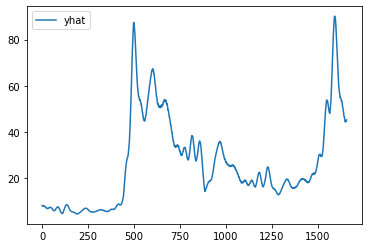

In [14]:
forecast_df[forecast_df['tic']=='ETCUSDT'].plot(y='yhat')

In [15]:
predict_df = forecast_df[forecast_df['tic']=='ETCUSDT']
predict_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,tic
0,2020-01-01,12.300558,1.874354,14.362222,12.300558,12.300558,-0.336755,-0.336755,-0.336755,-0.003420,-0.003420,-0.003420,-0.333336,-0.333336,-0.333336,0.0,0.0,0.0,8.158282,ETCUSDT
1,2020-01-02,12.224753,1.590289,14.945550,12.224753,12.224753,-0.322715,-0.322715,-0.322715,0.005606,0.005606,0.005606,-0.328322,-0.328322,-0.328322,0.0,0.0,0.0,8.279638,ETCUSDT
2,2020-01-03,12.148948,1.923726,14.721088,12.148948,12.148948,-0.320846,-0.320846,-0.320846,0.002403,0.002403,0.002403,-0.323249,-0.323249,-0.323249,0.0,0.0,0.0,8.251008,ETCUSDT
3,2020-01-04,12.073144,1.966983,15.205554,12.073144,12.073144,-0.313554,-0.313554,-0.313554,0.004688,0.004688,0.004688,-0.318242,-0.318242,-0.318242,0.0,0.0,0.0,8.287563,ETCUSDT
4,2020-01-05,11.997339,1.876780,14.658172,11.997339,11.997339,-0.312639,-0.312639,-0.312639,0.000784,0.000784,0.000784,-0.313423,-0.313423,-0.313423,0.0,0.0,0.0,8.246504,ETCUSDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,2024-07-12,51.497698,31.964563,58.569805,38.413548,66.211834,-0.131313,-0.131313,-0.131313,0.002403,0.002403,0.002403,-0.133716,-0.133716,-0.133716,0.0,0.0,0.0,44.735381,ETCUSDT
1655,2024-07-13,51.610797,31.896245,59.567072,38.354745,66.504932,-0.128713,-0.128713,-0.128713,0.004688,0.004688,0.004688,-0.133401,-0.133401,-0.133401,0.0,0.0,0.0,44.967810,ETCUSDT
1656,2024-07-14,51.723896,32.195192,58.634067,38.206803,66.871999,-0.130906,-0.130906,-0.130906,0.000784,0.000784,0.000784,-0.131690,-0.131690,-0.131690,0.0,0.0,0.0,44.952910,ETCUSDT
1657,2024-07-15,51.836995,31.653043,59.800657,38.058417,67.202471,-0.134456,-0.134456,-0.134456,-0.005797,-0.005797,-0.005797,-0.128659,-0.128659,-0.128659,0.0,0.0,0.0,44.867177,ETCUSDT


In [16]:
predict_df['trend'].max()

67.65015009717598

In [17]:
    current_price = filtered_data[filtered_data['tic']==tic]['close'].iloc[-1]
    single_df = forecast_df[forecast_df['tic']==tic]
    predict_df = single_df[single_df['ds']>max_date]
    volatility = np.mean((predict_df['yhat_upper']-predict_df['yhat_lower'])/predict_df['yhat'])
    predict_value_max = predict_df['yhat'].max()/current_price
    predict_value_min = predict_df['yhat'].min()/current_price
    new_data = {'tic':tic, 'max': predict_value_max, 'min':predict_value_min, 'volatility':volatility}
    static_df = static_df.append(new_data, ignore_index=True)
static_df

,tic,max,min,volatility
0,1INCHUSDT,0.967932,0.368761,2.435571
1,AAVEUSDT,0.850491,0.430250,1.052607
2,ADAUSDT,1.484622,1.094251,0.337481
3,AGLDUSDT,2.926914,1.327856,0.193900
4,ALGOUSDT,0.944768,0.518320,1.623854
...,...,...,...,...
127,YFIUSDT,1.435645,0.739600,1.008360
128,YGGUSDT,1.566571,0.343023,1.314771
129,ZILUSDT,1.294866,0.465457,1.250551
130,ZRXUSDT,0.605256,0.265328,0.731431
